# Adaboost

In [141]:
# Libraries
import numpy as np
import pandas as pd
from sklearn import tree
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier

## 1. Dataset

In [75]:


#re-create a hypothetical dataset
data = {'Temperature': ["Cold","Hot","Cold","Hot","Hot"],
        'Humidity': ["Normal","Normal","Normal","High","High"],
        'Outlook': ["Rain","Rain","Sunny","Sunny","Rain"], 
        'Wind': ["Strong","Weak","Weak","Weak","Weak"],
        'Hours': ["No", "No", "Yes", "Yes", "Yes"]
       }  

#transform dataset into a DataFrame df using pandas library
df = pd.DataFrame(data)  
  
#print the output
df


,Temperature,Humidity,Outlook,Wind,Hours
0,Cold,Normal,Rain,Strong,No
1,Hot,Normal,Rain,Weak,No
2,Cold,Normal,Sunny,Weak,Yes
3,Hot,High,Sunny,Weak,Yes
4,Hot,High,Rain,Weak,Yes


In [98]:
def calc_gini_impurity(y: np.ndarray, 
                       first_classname: str = 'Yes', 
                       second_classname: str = 'No') -> float:
    '''
    This function calculates Gini Impurity Score
    '''
    # Finding length of dataset
    n = y.shape[0]
    
    # Calculating probabilities of each class by dividing number
    # of class occurancies by length of dataset.
    p_0 = y[y == first_classname].shape[0] / n
    p_1 = y[y == second_classname].shape[0] / n
    
    # Just applying formula from the textbook.
    G = p_0 * (1 - p_0) + p_1 * (1 - p_1)

    return G, n

def calc_gini_gain(gini:float,
                   g_class0:float,
                   n_class0:int,
                   g_class1:float,
                   n_class1:int):
    N = n_class0+n_class1
    return gini - (n_class0/N*g_class0+n_class1/N*g_class1)

## 2. Building Adaboost

### 2.1. Weight 0

At the start, all samples get the same weight, one divided by the total number of samples:

*(Note that after we make the first tree, these weights will change in order to guide how the next tree is created)*

In [99]:
df["Weight"] = 1/len(df)
df

,Temperature,Humidity,Outlook,Wind,Hours,Weight
0,Cold,Normal,Rain,Strong,No,0.2
1,Hot,Normal,Rain,Weak,No,0.2
2,Cold,Normal,Sunny,Weak,Yes,0.2
3,Hot,High,Sunny,Weak,Yes,0.2
4,Hot,High,Rain,Weak,Yes,0.2


Then we find the variable among Temperature, Humidity, Outlook and Wind, that does the best job classifying the samples. (whose Gini Gain is the largest)

For that, we need to find Gini of the entire dataset:

In [106]:
gini, n = calc_gini_impurity(df.Hours)
gini

0.48

#### Temperature

In [107]:
g_cold, n_cold = calc_gini_impurity(df.Hours[df.Temperature=="Cold"])
g_hot, n_hot = calc_gini_impurity(df.Hours[df.Temperature=="Hot"])

g_gain_temp = calc_gini_gain(gini, g_cold, n_cold, g_hot, n_hot)
print(g_gain_temp)

0.013333333333333308


#### Humidity

In [108]:
g_normal, n_normal = calc_gini_impurity(df.Hours[df.Humidity=="Normal"])
g_high, n_high = calc_gini_impurity(df.Hours[df.Humidity=="High"])

g_gain_humidity = calc_gini_gain(gini, g_normal, n_normal, g_high, n_high)
print(g_gain_humidity)


0.21333333333333332


#### Outlook

In [116]:
g_rain, n_rain = calc_gini_impurity(df.Hours[df.Outlook=="Rain"])
g_sunny, n_sunny = calc_gini_impurity(df.Hours[df.Outlook=="Sunny"])

g_gain_outlook = calc_gini_gain(gini, g_rain, n_rain, g_sunny, n_sunny)
print(g_gain_outlook)

0.21333333333333332


#### Wind

In [117]:
g_strong, n_strong = calc_gini_impurity(df.Hours[df.Wind=="Strong"])
g_weak, n_weak = calc_gini_impurity(df.Hours[df.Wind=="Weak"])

g_gain_wind = calc_gini_gain(gini, g_strong, n_strong, g_weak, n_weak)
print(g_gain_wind)

0.17999999999999994


Humidity won. The tree is the following:

In [111]:
df_enc = pd.get_dummies(df)
X = df_enc[["Temperature_Cold","Humidity_Normal", "Outlook_Rain", "Wind_Strong"]]
y = df_enc.Hours_Yes.values


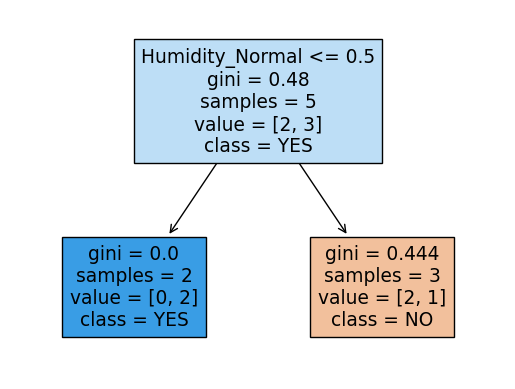

In [115]:
# Initialize the model
clf = DecisionTreeClassifier(criterion='gini', max_depth=1)
# Train the model
clf.fit(X, y)
#plot
fig_tree = tree.plot_tree(clf, 
                          feature_names=["Temperature_Cold", "Humidity_Normal", "Outlook_Rain", "Wind_Strong"],  
                          class_names=['NO', 'YES'],
                          filled=True)

## Amount of Say

Now we need to determine how much say this tree will have in a final classification. We do that based on how well it classifies the samples. 

The tree makes one error (observation #2: Wind=Weak, should be "YES" but is "NO".

We can calculate the amount of say using the following equation:

$$
Amount \ of \ Say = \frac{1}{2} \cdot log \Big(\frac{1- Total \ Error}{Total \ Error} \Big)
$$

In [119]:
amount_of_say = 1/2 * np.log((1-0.2)/0.2)
amount_of_say

0.6931471805599453

And the amount of say is pretty high. 

In [120]:
#Provide another example?

Now we need to understand how to modify the weights so that the next stump will take the errors that the current stumo made into account. This is the formula we will use to **increase** the Sample Weight for the sample that was **incorrectly** classified (onbservation #2)

$$
New \ Sample \ Weight = w_{sample} * e^{amount \ of \ say}
$$

In [125]:
0.2*np.e**amount_of_say

0.39999999999999997

This is the formula we will use to **decrease** the Sample Weight for the sample that was correctly classified (all observations but #2)

$$
New \ Sample \ Weight = w_{sample} * e^{-amount \ of \ say}
$$

In [126]:
0.2*np.e**(-amount_of_say)

0.1

The new sample weight is 0.16 which is less that the previous (0.2).

In [133]:
df["Weight_1"] = [0.1,0.1,0.4,0.1,0.1]
df

,Temperature,Humidity,Outlook,Wind,Hours,Weight,Weight_1,Weight_Agg
0,Cold,Normal,Rain,Strong,No,0.2,0.1,0.125
1,Hot,Normal,Rain,Weak,No,0.2,0.1,0.250
2,Cold,Normal,Sunny,Weak,Yes,0.2,0.4,0.750
3,Hot,High,Sunny,Weak,Yes,0.2,0.1,0.875
4,Hot,High,Rain,Weak,Yes,0.2,0.1,1.000


Now, we need to normalize the sample weights so that they add up to one. Right now if you add up Weight_1 column, you get 1.03. To do that, we divide new sample weight by 1.03.

In [134]:
df["Weight_1"] = df["Weight_1"]/0.8
df

,Temperature,Humidity,Outlook,Wind,Hours,Weight,Weight_1,Weight_Agg
0,Cold,Normal,Rain,Strong,No,0.2,0.125,0.125
1,Hot,Normal,Rain,Weak,No,0.2,0.125,0.250
2,Cold,Normal,Sunny,Weak,Yes,0.2,0.500,0.750
3,Hot,High,Sunny,Weak,Yes,0.2,0.125,0.875
4,Hot,High,Rain,Weak,Yes,0.2,0.125,1.000


Now when we add up the new sample weight (weight 1) we get 1 (+- a little rounding error).

The reason why in boosting, the weight is higher for unclassified data points, is because the adaboost will put more emphasis on correctly classifying this sample (the one that was misclassified by the last stump).

In [135]:
0.75+0.125+0.125

1.0

In [138]:
df["Weight_Agg"] = ['0 - 0.125', '0.125 - 0.25', '0.25 - 0.75', '0.75 - 0.875', '0.875 - 1']
df

,Temperature,Humidity,Outlook,Wind,Hours,Weight,Weight_1,Weight_Agg
0,Cold,Normal,Rain,Strong,No,0.2,0.125,0 - 0.125
1,Hot,Normal,Rain,Weak,No,0.2,0.125,0.125 - 0.25
2,Cold,Normal,Sunny,Weak,Yes,0.2,0.500,0.25 - 0.75
3,Hot,High,Sunny,Weak,Yes,0.2,0.125,0.75 - 0.875
4,Hot,High,Rain,Weak,Yes,0.2,0.125,0.875 - 1


## Next dataset

we start by making a new dataset. We do so by randomly picking a number between 0 and 1, and see where this value falls when we use the weights like a distribution. We contunue until the dataset is the same size as the original. 

For example, if a number is betwen 0 and 0.155, then we would put this sample into the new collection of samples. 
And if the number is between 0.155 and 0.54 (0.155+0.38835), we would put this sample into the new collection.

0 - 0.155 - 0.53 - 0.695 - 0.85 - 1

- For example, imagine the first number I picked is 0.82. Then I would put sample #4 into the dataset. 
- Then I picked another random number, 0.18, and put #2 into the dataset. 
- Then I picked another random number, 0.46, and put #2 into the dataset. 
- Then I picked another random number, 0.92, and put #5 into the dataset.
- Finally, I picked another random number, 0.31, and put #2 into the dataset. 

In [72]:


#re-create a hypothetical dataset
data2 = {'Temperature': ["Hot","Hot","Hot","Cold","Hot"],
        'Humidity': ["High","High","High","High","High"],
        'Outlook': ["Sunny","Sunny","Sunny","Rain","Sunny"], 
        'Wind': ["Weak","Weak","Weak","Weak","Weak"],
        'Hours': ["Yes", "No", "No", "Yes", "No"]
       }  

#transform dataset into a DataFrame df using pandas library
df2 = pd.DataFrame(data2)  
  
#print the output
df2


,Temperature,Humidity,Outlook,Wind,Hours
0,Hot,High,Sunny,Weak,Yes
1,Hot,High,Sunny,Weak,No
2,Hot,High,Sunny,Weak,No
3,Cold,High,Rain,Weak,Yes
4,Hot,High,Sunny,Weak,No


Ultimately, observation #2 was added to the new collection of samples 3 times, reflecting its larger sample weight.

Lastly, we use this dataset, and again, give new weights, just like before.

In [73]:
df2["Weight"] = 1/len(df2)
df2

,Temperature,Humidity,Outlook,Wind,Hours,Weight
0,Hot,High,Sunny,Weak,Yes,0.2
1,Hot,High,Sunny,Weak,No,0.2
2,Hot,High,Sunny,Weak,No,0.2
3,Cold,High,Rain,Weak,Yes,0.2
4,Hot,High,Sunny,Weak,No,0.2


However, that does not mean the next tree will not emphasize the need to correctly classify these samples. Because these three samples (#2, #3, #5) are all the same, they will be treated as a block creating a large penalty for being misclassified. Let'see:

Again, we find the best candidate to split this dataset. 

This is how the errors that the first tree makes, influence how the second tree is made. And the errors that the second tree makes influence how the third tree is made. 

How classification is made with Adaboost? 

We have two groups: 3 stumpts that say YES in one group, and 2 stumps that say NO in another. We look at the amount of say of each group by suming up amounts of say of each tree in the furst group, as well as in the second. We give a prediction of a group that has higher total of amounts of say.

# AdaBoost Algo

In [142]:
df = pd.read_csv("https://raw.githubusercontent.com/5x12/ml-cookbook/master/supplements/data/heart.csv")

In [153]:
X = df.iloc[:, :13]
y = df.target

In [154]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=101)

In [156]:
clf = AdaBoostClassifier(random_state=96)

In [157]:
clf.fit(X_train, y_train)

AdaBoostClassifier(random_state=96)

In [158]:
clf.score(X_test, y_test)

0.9066147859922179

In [159]:
clf.score(X_train, y_train)

0.9192708333333334

In [171]:
train_error = []
test_error = []
n = []

for i in range(1, 1000):
    print(i)
    clf = AdaBoostClassifier(n_estimators=i, random_state=96)
    clf.fit(X_train, y_train)
    train_error.append(1-clf.score(X_train, y_train))
    test_error.append(1-clf.score(X_test, y_test))
    n.append(i)
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [164]:
import matplotlib.pyplot as plt 

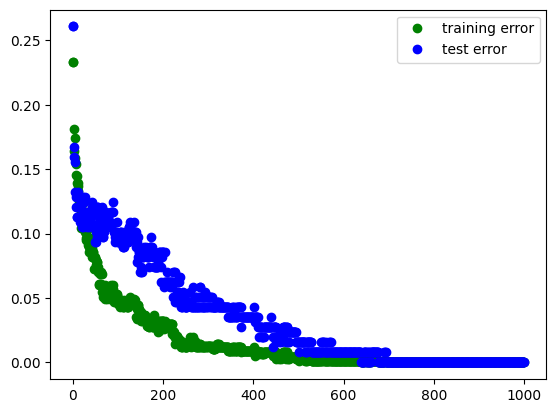

In [173]:
#define the graph
fig, ax = plt.subplots()

#plotting training dataset
ax.plot(n, train_error, 'o', color='g', label='training error')
ax.plot(n, test_error, 'o', color='b', label='test error')

#showing legend and setting the size of the graph
plt.legend(); #show legend
# plt.ylim(0, 0.28) #length of y-axis
# plt.xlim(0, 110) #length of x-axis
